In [5]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import math

In [6]:
class ImagesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.classification = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.classification)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                f'{self.classification.iloc[idx, 0]}')
        image = io.imread(img_name)
        class_num = self.classification.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, class_num

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [8]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        logits = model(data)
        loss = F.cross_entropy(logits, target)

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / target.size(0)

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

@torch.no_grad()
def make_predictions(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:

        data = data.to(device)
        target = target.to(device)

        logits = model(data)

        category = (logits.argmax(dim=1) == target).sum() / target.size(0)

        acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:

        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        acc = (logits.argmax(dim=1) == target).sum() / target.size(0)

        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step(val_loss)

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [9]:
n_classes = 200

class BottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, is_first=False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels*4, kernel_size=1, stride=1)
        self.bn3 = nn.BatchNorm2d(out_channels*4)
        self.relu = nn.ReLU()

        self.downsample = None
        if is_first:
          self.downsample = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                                    out_channels=out_channels*4,
                                                    kernel_size=1,
                                                    stride=stride),
                                            nn.BatchNorm2d(out_channels*4))

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
          out += self.downsample(x)
        else:
          out += x
        out = self.relu(out)

        return out

@torch.no_grad()
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, 0, math.sqrt(2 / m.in_features))
    elif type(m) == nn.Conv2d:
        nn.init.normal_(m.weight, 0, math.sqrt(2 / m.in_channels))

In [10]:
transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.RandomChoice([transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip()], p=[0.5, 0.5]),
         transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

trainval_dataset = ImagesDataset(csv_file='/kaggle/input/bhw-1-dl-2024-2025/bhw1/labels.csv', root_dir='/kaggle/input/bhw-1-dl-2024-2025/bhw1/trainval/', transform=transform)

train_idx, valid_idx = train_test_split(np.arange(len(trainval_dataset)), test_size=0.1, shuffle=True, random_state=0)

trainset = torch.utils.data.Subset(trainval_dataset, train_idx)
valset = torch.utils.data.Subset(trainval_dataset, valid_idx)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(valset, batch_size=128, shuffle=False, num_workers=2)

In [11]:
class ResNet_50_v8(nn.Module):
  def __init__(self, in_channels=3):
      super().__init__()

      self.conv1 = nn.Sequential(nn.Conv2d(in_channels=in_channels,
                                           out_channels=64,
                                           kernel_size=4,
                                           stride=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU())

      self.conv2_x = self.CreateLayerBootleNeck(n_blocks=3,
                                                 in_channels=64,
                                                 out_channels=64,
                                                 stride=1)
      self.conv3_x = self.CreateLayerBootleNeck(n_blocks = 4,
                                                 in_channels = 256,
                                                 out_channels = 128,
                                                 stride=2)
      self.conv4_x = self.CreateLayerBootleNeck(n_blocks = 6,
                                                 in_channels = 512,
                                                 out_channels = 256,
                                                 stride=2)
      self.conv5_x = self.CreateLayerBootleNeck(n_blocks = 3,
                                                 in_channels = 1024,
                                                 out_channels = 512,
                                                 stride=2)
      
      self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
      self.pool = nn.AdaptiveAvgPool2d((1, 1))
      self.dropout = nn.Dropout(p=0.7)
      self.linear = nn.Linear(2048, 200)
      self.apply(init_weights)


  def forward(self, x):
      x = self.conv1(x)
      x = self.conv2_x(x)
      x = self.conv3_x(x)
      x = self.maxpool(x)
      x = self.conv4_x(x)
      x = self.maxpool2(x)
      x = self.conv5_x(x)

      x = self.pool(x)
      x = x.reshape(x.shape[0], -1)
      x = self.dropout(x)
      x = self.linear(x)

      return x


  def CreateLayerBootleNeck(self, n_blocks, in_channels, out_channels, stride=1):
      layer = []
      for i in range(n_blocks):
          if not i:
              layer.append(BottleNeck(in_channels, out_channels, is_first=True))
          else:
              layer.append(BottleNeck(out_channels*4, out_channels))

      return nn.Sequential(*layer)

In [12]:
print(sum(p.numel() for p in ResNet_50_v8().parameters()))

23938056


In [13]:
net = ResNet_50_v8().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 50, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 5.76667871800336, train acc: 0.007013494318181818
 val loss: 5.247211896920506, val acc: 0.009988132911392405

Epoch 1
 train loss: 5.114324077963829, train acc: 0.017811168323863636
 val loss: 4.916453439978104, val acc: 0.03322784810126582

Epoch 2
 train loss: 4.834431383420121, train acc: 0.03695401278409091
 val loss: 4.6650309562683105, val acc: 0.0568631329113924

Epoch 3
 train loss: 4.618419250304049, train acc: 0.05870472301136364
 val loss: 4.459613096864918, val acc: 0.08623417721518987

Epoch 4
 train loss: 4.416395157575607, train acc: 0.08249733664772728
 val loss: 4.291775658160826, val acc: 0.10571598101265822

Epoch 5
 train loss: 4.2297637157819485, train acc: 0.10540216619318182
 val loss: 4.10503371757797, val acc: 0.12569224683544303

Epoch 6
 train loss: 4.032872321930799, train acc: 0.1307373046875
 val loss: 3.8494985254505014, val acc: 0.16010680379746836

Epoch 7
 train loss: 3.844445202160965, train acc: 0.15577281605113635
 val loss: 3.

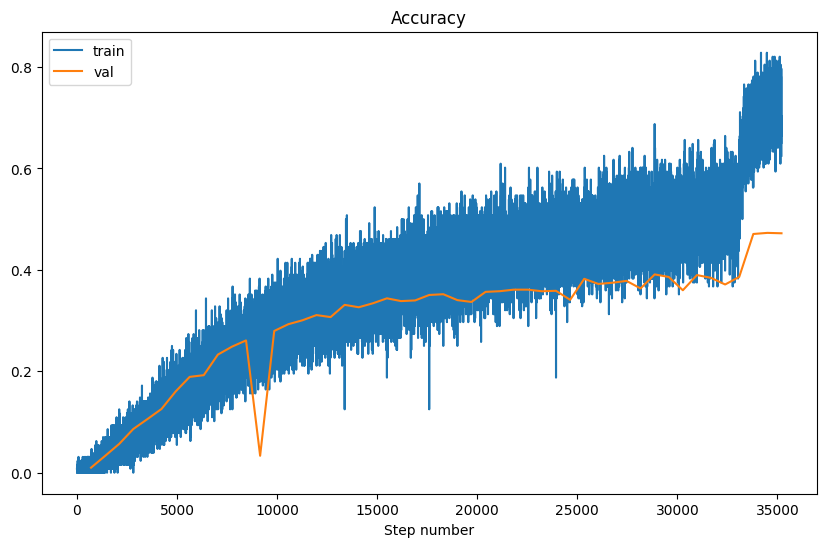

In [14]:
plt.figure(figsize=(10,6))
plt.title("Accuracy")
plt.xlabel("Step number")
plt.plot(range(len(tr_acc_log)), tr_acc_log)
plt.plot((np.arange(len(val_acc_log)) + 1) * len(train_loader), val_acc_log)
plt.legend(['train', 'val'])
plt.show()

In [15]:
class TestImagesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.classification = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.classification)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                f'{self.classification.iloc[idx, 0]}')
        image = io.imread(img_name)
        image_name = self.classification.iloc[idx, 0]

        if self.transform:
            image = self.transform(image)

        return image, image_name

In [17]:
transform = transforms.Compose(
        [transforms.ToPILImage(),
         transforms.ToTensor(),
         transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]
)

test_dataset = TestImagesDataset(csv_file='/kaggle/input/bhw-1-dl-2024-2025/bhw1/sample_submission.csv', root_dir='/kaggle/input/bhw-1-dl-2024-2025/bhw1/test/', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [18]:
df_ans = pd.DataFrame(columns=['Id', 'Category'])

for data, labels in test_loader:
  data = data.to(device)
  logits = net(data)
  predictions = logits.argmax(dim=1)

  for pred, image_name in zip(predictions, labels):
    df_ans.loc[len(df_ans)] = [image_name, int(pred.cpu())]

In [19]:
df_ans.to_csv('/kaggle/working/labels_test.csv', index=False)